<h1>Part 1</h1>

In [1]:
import numpy as np
import nashpy as nash
import math
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exponential_weights(v, epsilon, h):
    """
    It gives suggestions to players for probabilities to pick actions given an array of previous payoffs 
    of those actions.

    Args:
      v: an array of payoffs for each action at a given turn
      epsilon: the learning rate
      h: the range of the payoffs
      
    Returns:
      weights: weights for each action at a given turn
      pi: optimal probabilities for picking each action at a given turn
    """
    V = np.cumsum(v, axis=1)
    weights = np.power((1 + epsilon), V[:, :-1]/h)
    # because we're referencing the previous column, the first
    # column of ones gets removed so we need to add it back
    weights = np.insert(weights, 0, np.ones(v.shape[0]), axis=1)
    pi = np.divide(weights, np.sum(weights, axis=0))
    return weights, pi

def nash_eq(A, B):
    """
    It takes in a matrix A and a matrix B, and returns the Nash equilibrium of the game defined by A and
    B
    
    Args:
      A: payoff matrix for player row
      B: payoff matrix for player column
    
    Returns:
      A list of tuples. Each tuple contains the row and column indices of the Nash equilibrium.
    """
    game = nash.Game(A, B)
    eq = game.support_enumeration()
    return eq

def generate_random_game():
    """
    It generates a random bimatrix game.
    
    Returns:
      A: 2x2 numpy array with integer values 0-9
      B: 2x2 numpy array with integer values 0-9
    """
    A = np.random.randint(0, 10, size=(2, 2))
    B = np.random.randint(0, 10, size=(2, 2))
    return A, B

# EW tests that return probabilities for all actions/rounds 
def test_exponential_weights(A, B, epsilon):
    """
    > We play the game 25 times, and at each round, we use the exponential weights algorithm to
    calculate the probability of each action, and then we pick an action randomly based on the
    probability. 
    
    We'll use the `test_exponential_weights` function
    
    Args
      A: payoff matrix for player A
      B: payoff matrix for player B
      epsilon: the learning rate

    Returns:
      pi_A: the probability of A taking each action in each round
      pi_B: the probability of A taking each action in each round
    """
    ROUNDS = 25
    payoffs_A = np.zeros([2, ROUNDS])
    payoffs_B = np.zeros([2, ROUNDS])
    for round in range(ROUNDS):
        _, pi_A = exponential_weights(payoffs_A[:, 0:round+1], epsilon, 10)
        _, pi_B = exponential_weights(payoffs_B[:, 0:round+1], epsilon, 10)
        action_A = random_pick(pi_A[:, round])
        action_B = random_pick(pi_B[:, round])
        payoffs_A[0][round] = A[0][action_B]
        payoffs_A[1][round] = A[1][action_B]
        payoffs_B[0][round] = B[action_A][0]
        payoffs_B[1][round] = B[action_A][1]
    _, pi_A = exponential_weights(payoffs_A, epsilon, 10)
    _, pi_B = exponential_weights(payoffs_B, epsilon, 10)
    return pi_A, pi_B

# randomly pick an index in the array according to the given probabilities in each element of the array
def random_pick(probability_array):
    """
    It generates a random number between 0 and 1, and then returns the index of the first element in the
    probability array that is greater than the random number
    
    Args:
      probability_array: an array of probabilities, where the sum of all the probabilities is 1.0
    
    Returns:
      The index of the element in the array that is greater than the random number.
    """
    random_number = np.random.random()
    cumulative_probability = 0.0
    for index, probability in enumerate(probability_array):
        cumulative_probability += probability
        if random_number < cumulative_probability:
            return index
    return len(probability_array) - 1

def monte_carlo_EW(epsilon):
    """
    It generates 100 random games, and for each game, it runs the exponential weights algorithm and
    checks if the results are within a reasonable threshold of the Nash equilibrium
    
    Args:
      epsilon: the learning rate

    Returns:
      The probability that the algorithm converges to a nash equilibrium.
    """
    N = 100
    converges_to_nash_count = 0
    for i in range(N):
        A, B = generate_random_game()
        pi_A, pi_B = test_exponential_weights(A, B, epsilon)
        eq = nash_eq(A, B)
        for i in eq:
            a_true_nash = i[0]
            a_results = pi_A[:, 24]
            a_converges = (abs(a_true_nash[0] - np.round(a_results[0])) < 0.1) & (abs(a_true_nash[1] - np.round(a_results[1])) < 0.1)
            b_true_nash = i[1]
            b_results = pi_B[:, 24]
            b_converges = (abs(b_true_nash[0] - np.round(b_results[0])) < 0.1) & (abs(b_true_nash[1] - np.round(b_results[1])) < 0.1)            
            if a_converges & b_converges:
                converges_to_nash_count += 1
    return converges_to_nash_count/N

def test_learning_rates_for_EW(divisor=1):
    """
    It runs a Monte Carlo simulation for each value of epsilon in the list epsilons, and returns the
    list of epsilons and the list of results
    
    Args:
      divisor: the learning rate is divided by this number. Defaults to 1
    
    Returns:
      The epsilons and the results
    """
    epsilons = [i/divisor for i in range(100)]
    results = [0 for i in range(len(epsilons))]
    for i, e in enumerate(epsilons):
        results[i] = monte_carlo_EW(e)

    return epsilons, results

def plot_learning_rates_for_EW(epsilons, results):
    """
    It plots the learning rates against the probability of convergence to Nash
    
    Args:
      epsilons: a list of learning rates
      results: a list of the probability of convergence to Nash for each learning rate
    """
    plt.plot(epsilons, results)
    plt.xlabel('Epsilon - Learning Rate')
    plt.ylabel('Pr[Convergence to Nash]')
    plt.show()

<h3>Test For Learning Rates Between 0 and 1</h3>

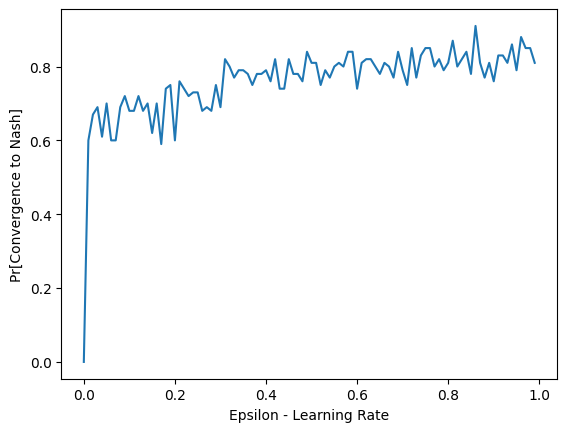

In [4]:
epsilons, results = test_learning_rates_for_EW(divisor=100)
plot_learning_rates_for_EW(epsilons, results)

<h3>Test For Learning Rates Between 0 and 1000</h3>

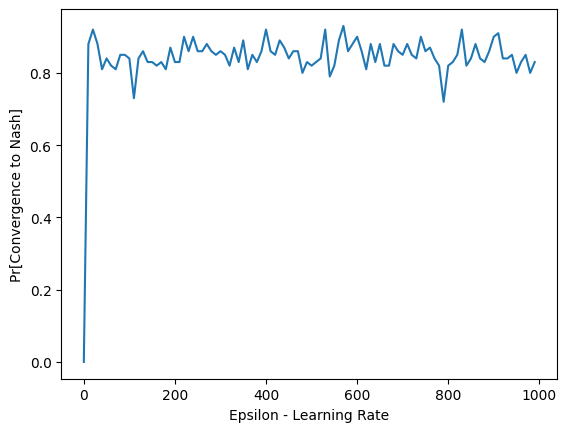

In [5]:
epsilons, results = test_learning_rates_for_EW(divisor=0.1)
plot_learning_rates_for_EW(epsilons, results)

<h1>Part 2</h1>

In [6]:
#strategy: look at the nash eq --> always pick the one where we have the highest payoff
def beat_learning_alg(A, B):
    game = nash.game(A,B)
    eq = game.support_enumeration()
    if eq[1][0] == 1:
        col = 0 
    else:
        col = 1

    play = max(B[0][col], B[1][col])
    return play 